## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.2 (main:00d8eb3, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")

CPU times: user 19.8 s, sys: 2min 21s, total: 2min 40s
Wall time: 2min 3s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with the sequence of the region

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

1143


(0.0, 351386.0)

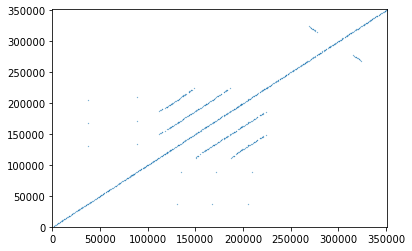

In [7]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', 'chrX_hg19', 153448084, 153499470
padding = 150000
roi_len = roi_e - roi_b
#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)
x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 32, 32, 12, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=1000000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 85
The total aligned regions is 85


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG00735#1#JAHBCH010000212.1', 'HG00735.paternal.f1_assembly_v2_genbank.fa', 36692) target region 394 - 35835 len: 35441
('NA18906#1#JAHEOO010000114.1', 'NA18906.paternal.f1_assembly_v2_genbank.fa', 9980297) target region 7978887 - 8368841 len: 389954
('HG01071#1#JAHBCF010000036.1', 'HG01071.paternal.f1_assembly_v2_genbank.fa', 12707721) target region 10772672 - 11123412 len: 350740
('HG00733#2#JAHEPP010000192.1', 'HG00733.maternal.f1_assembly_v2_genbank.fa', 2540695) target region 1265776 - 1616498 len: 350722
('HG01175#1#JAHAMA010000131.1', 'HG01175.paternal.f1_assembly_v2_genbank.fa', 10053075) target region 8743318 - 9094079 len: 350761
('HG02717#2#JAHAOR010000111.1', 'HG02717.maternal.f1_assembly_v2_genbank.fa', 9217333) target region 7242655 - 7594190 len: 351535
('HG01952#2#JAHAMD010000106.1', 'HG01952.maternal.f1_assembly_v2_genbank.fa', 2969852) target region 1617940 - 1932294 len: 314354
('HG00741#1#JAHALY010000098.1', 'HG00741.paternal.f1_assembly_v2_genbank.fa', 2927439) t

Text(0, 0.5, 'count')

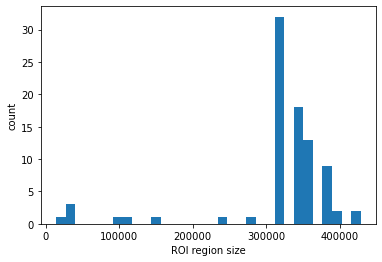

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI region size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots. We label the region of the ROI by two vertical grey lines. We observe that there are different number of intersections (~different copy number) of the region the "dots" due to the different repeat structures.

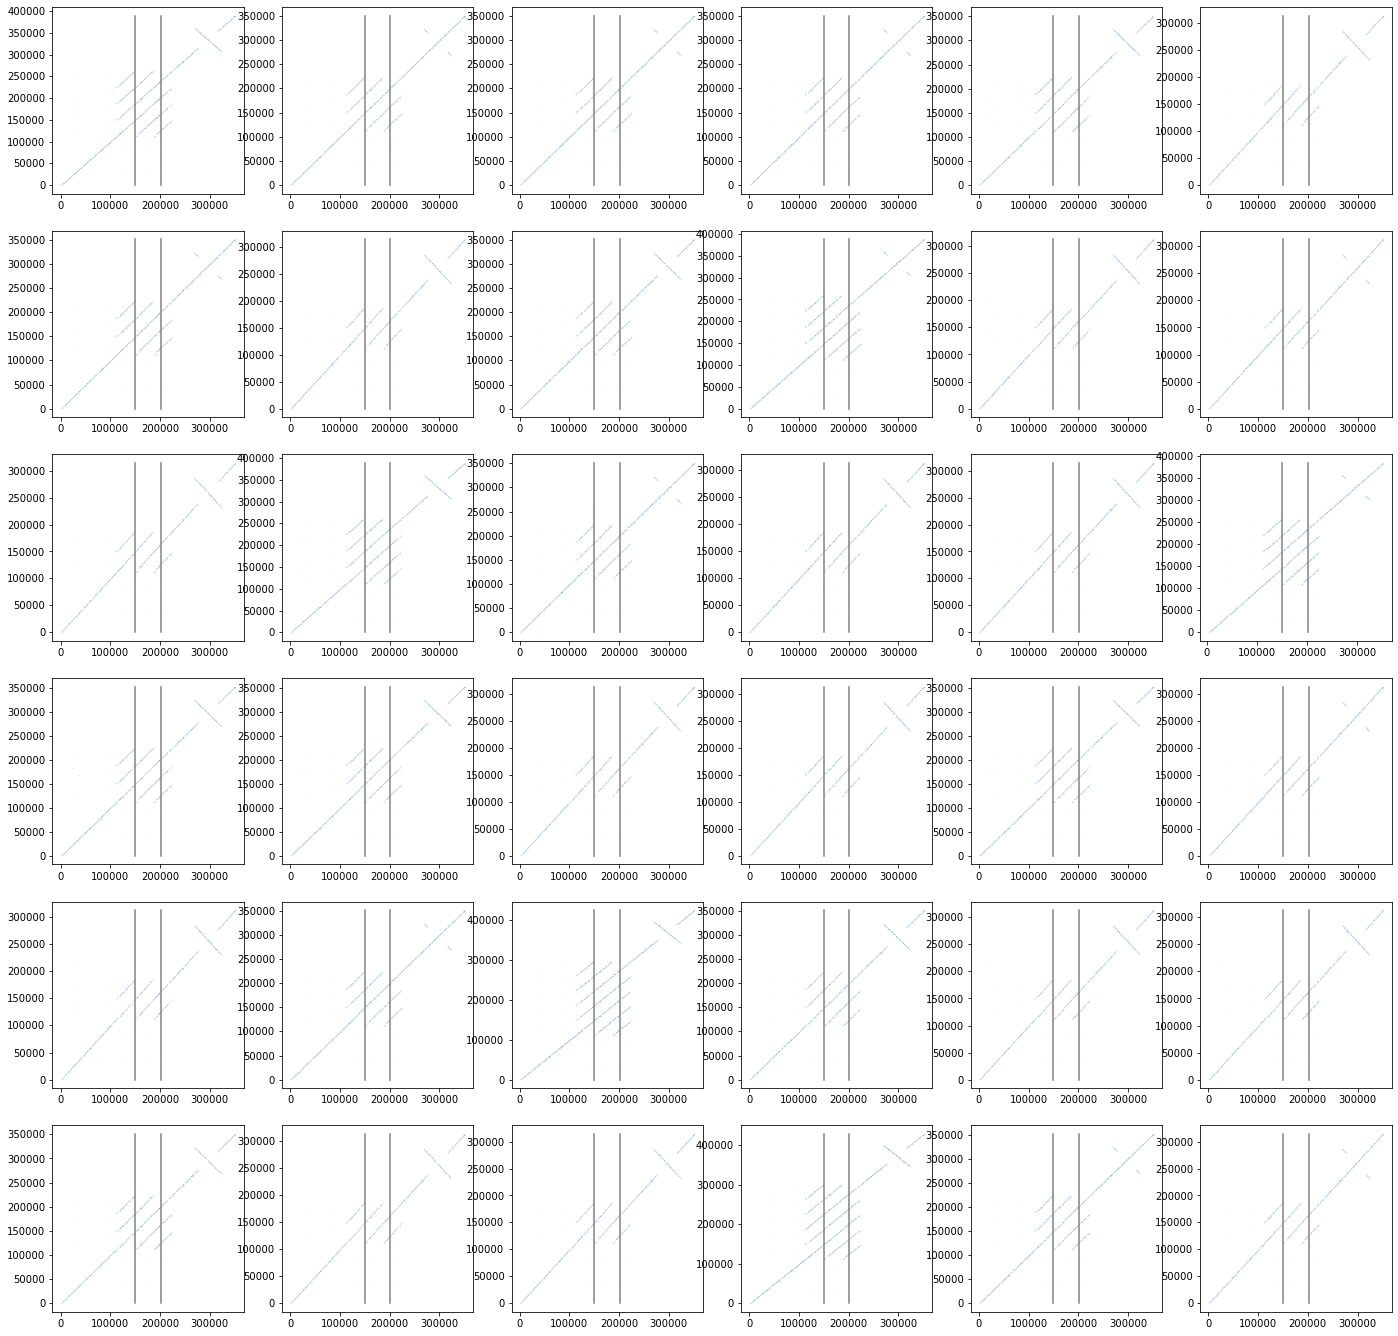

In [11]:
seq_list = []
i = 1
plt.figure(figsize=(24, 24))
for k in list(aln_range.keys()):
    ctg_name, source, _ = sdb.seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()

    rgns = pgrtk.merge_regions(rgns, tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
  
        if aln[0][0][0] > padding or aln[-1][0][1] < padding + roi_len:
            continue
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
  
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 32, 32, 12, 1)
        
        
        if i <= 36:
            plt.subplot(6,6,i)
            plt.plot(x, y, ".", markersize=0.1)
            plt.plot([padding, padding],[0, max(y)], color='grey')
            plt.plot([padding+roi_len, padding+roi_len],[0, max(y)], color='grey')
        i += 1
        
        
        
        

## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
seq_info = sdb.seq_info.copy()
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue
            
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=128, k=56, r=12, min_span=28)

In [14]:
len(new_sdb.seq_info)

77

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 77
The total aligned regions is 77


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 77


Text(0, 0.5, 'count')

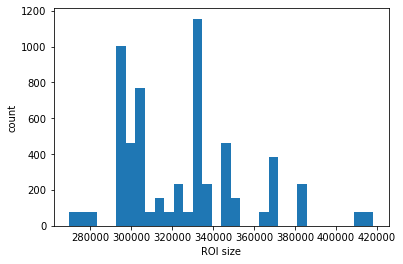

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

In [19]:
f0 = open("/results/ROI_seq.fa", "w")
for ctg, seq in seq_list:
    
    print(">{}".format(ctg), file=f0)
    print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

In [20]:
help(new_sdb.generate_mapg_gfa)

Help on built-in function generate_mapg_gfa:

generate_mapg_gfa(...) method of builtins.SeqIndexDB instance
    Convert the adjecent list of the shimmer graph shimmer_pair -> GFA
    
    Parameters
    ----------
    min_count : int
        the minimum number of times a pair of shimmers must be observed to be included in the graph
    
    filenpath : string
        the path to the output file
    
    Returns
    -------
    
    None
        The data is written into the file at filepath



In [21]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=128, k=56, r=12, min_span=28)
new_sdb.generate_mapg_gfa(0, "/results/ROI_80_56_6.gfa")

new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=128, k=56, r=2, min_span=28)
new_sdb.generate_mapg_gfa(0, "/results/ROI_80_56_2.gfa")

## Construct the genome graphs

In [22]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [23]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    node_to_sid = {}
    for v in G.nodes():
        node_to_sid.setdefault(v, {})
        for sid, path in sid_to_path.items():
            node_to_sid[v][sid] = 0
            
     
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            node_to_sid[v][sid] = 1
    #nx.set_node_attributes(G, node_to_sid)  
    return G
    

In [24]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

## Generate Repeat Pattern Using the Principal Bundles

In [25]:
len(seq_list)

77

In [26]:
import numpy as np

In [27]:
shmmrspec = {"w": 80, "k":56, "r":4, "min_span":28 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])

In [28]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_smps = dict(sid_smps)
print(len(principal_bundles))

20


In [29]:
import numpy as np
from matplotlib import cm

In [30]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [45]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (8011*5) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[ 0 15 10  5  0 15 10  5  0 15 10  5  0 15 10  5  0 15 10  5]


In [46]:
new_sdb.generate_mapg_gfa(0, "/results/test_48_56_4_28.gfa")

v_to_name = {}
with open("/results/test_48_56_4_28.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/test_48_56_4_28_color.csv", "w")
print("Name,Color", file=f)
for bundle_id, bundle in enumerate(principal_bundles):
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = color_theme[bundle_id]
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, file=f, sep=",")
f.close()

In [47]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

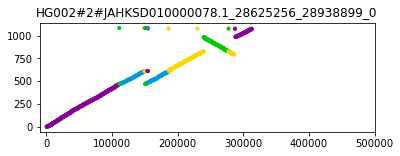

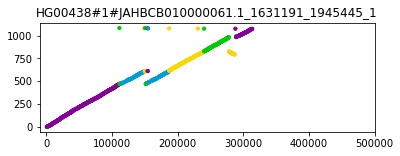

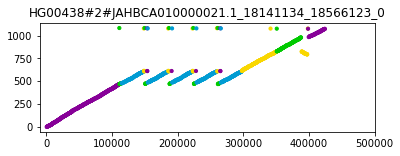

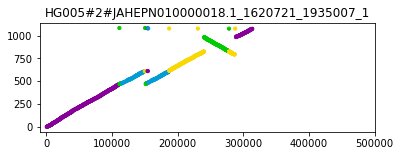

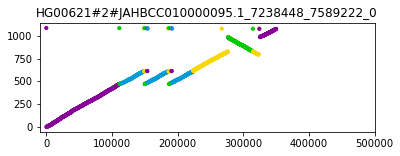

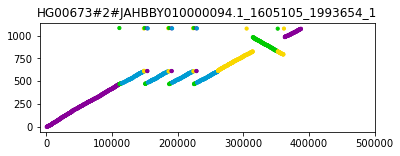

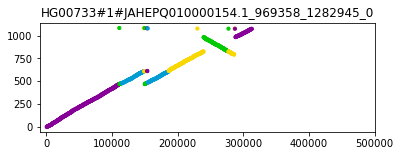

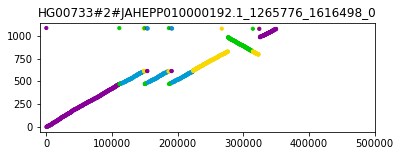

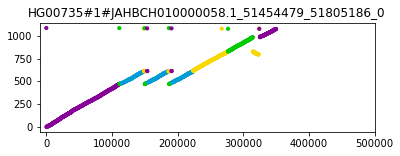

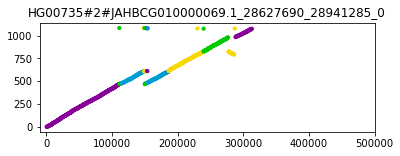

In [48]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []

   
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,500000)
    plt.title(ctg)
    

In [49]:
ref_file_name, roi1_chr, roi1_b, roi1_e = 'hg19_tagged.fa', 'chrX_hg19', 153409725,153424507

padding = 100
roi1_seq = ref_db.get_sub_seq(ref_file_name, roi1_chr, roi1_b-padding, roi1_e+padding)

    
ref_file_name, roi2_chr, roi2_b, roi2_e = 'hg19_tagged.fa', 'chrX_hg19', 153485203,153499470
padding = 100
roi2_seq = ref_db.get_sub_seq(ref_file_name, roi2_chr, roi2_b-padding, roi2_e+padding)


ref_file_name, roi3_chr, roi3_b, roi3_e = 'hg19_tagged.fa', 'chrX_hg19', 153576900, 153603006
padding = 100
roi3_seq = ref_db.get_sub_seq(ref_file_name, roi3_chr, roi3_b-padding, roi3_e+padding)




In [50]:
gene_matches1 = new_sdb.get_match_positions_with_fragment(roi1_seq)
gene_matches2 = new_sdb.get_match_positions_with_fragment(roi2_seq)
gene_matches3 = new_sdb.get_match_positions_with_fragment(roi3_seq)


gene_matches = [gene_matches1, gene_matches2, gene_matches3]

<Figure size 1728x4608 with 0 Axes>

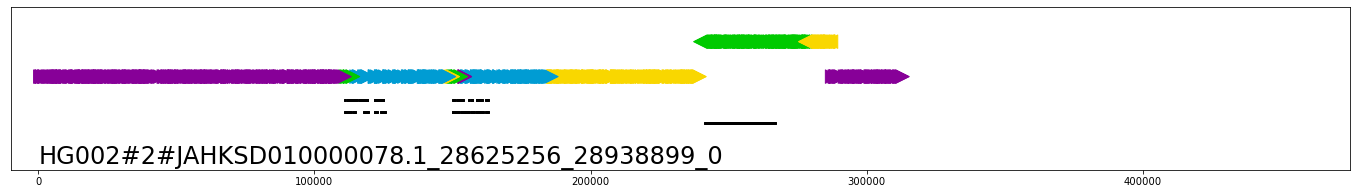

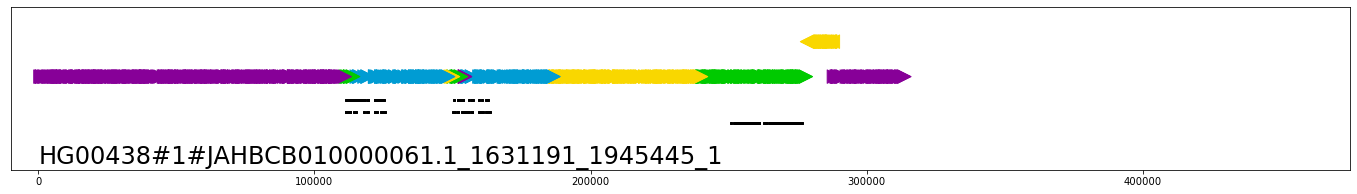

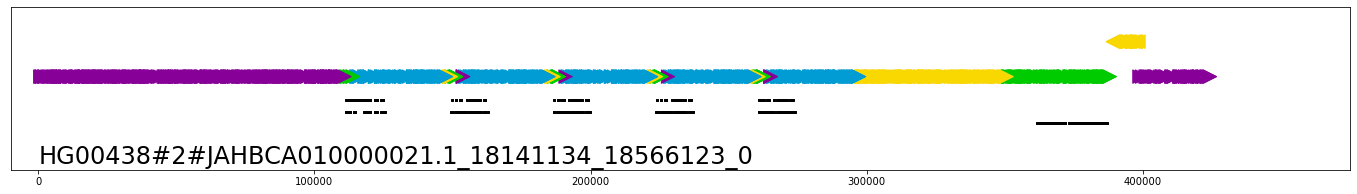

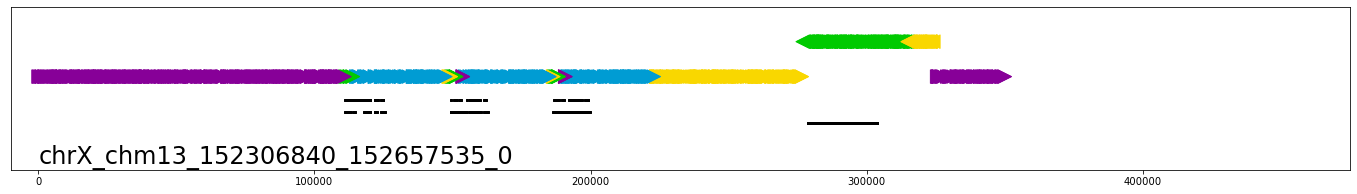

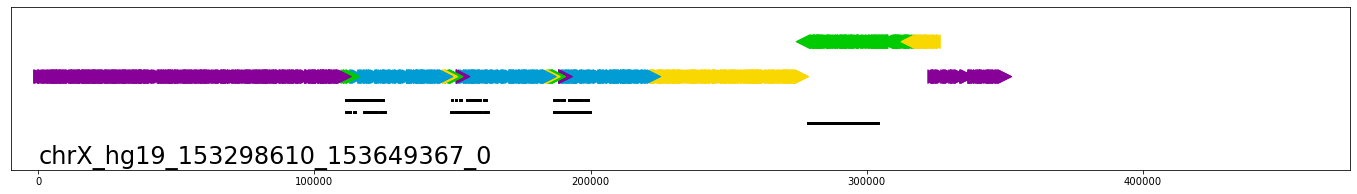

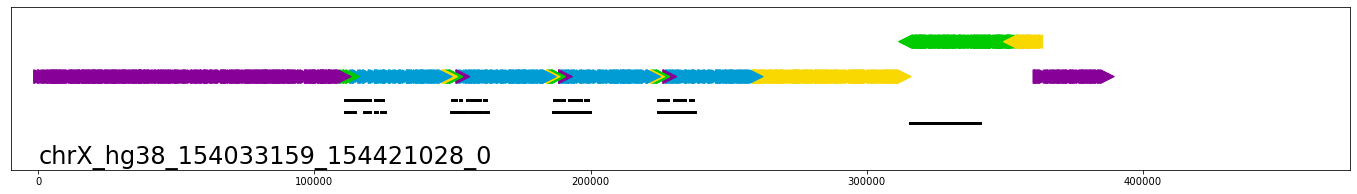

In [51]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,64))
# pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    if ctg[:5] not in ["HG002", "HG004", "chrX_"]:
        continue
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    # plt.subplot(len(sid_smps), 1, pidx)
    # pidx += 1
    
    plt.figure(figsize=(24,3))
    plt.scatter(x, y, marker=">", color=c, s=180)
    plt.scatter(rx, ry, marker="<", color=rc, s=180)
    
    
    for mi in range(len(gene_matches)):
        matches = set([(_[0], _[1]) for _ in gene_matches[mi][sid]])
        track_x = [_[0] for _ in matches]
        plt.scatter(track_x, [-4-mi*2]*len(track_x), marker="s", color="black", s=2)
  
    
    
    
    #plt.axis("off")
    plt.yticks([])
    plt.ylim(-16,12)
    plt.xlim(-10000,475000)
    plt.text(0, -15, ctg, fontsize=24)